## НЛП: классификация по нескольким меткам пользовательского опыта



### Введение:

Команда машинного обучения Samokat.tech создает модели для прогнозирования будущего, планирования ассортимента, роботизации логистики, автогенерации пользовательского контента и для многих других задач.

### Постановка задачи

Команда машинного обучения пользовательского контента занимается внедрением ML-сервисов как для модерации контента, который публикует пользователей, так и для генерации нового контента на карточках CE.

В основном они работают с текстовыми данными. Для решения поставленных задач используют разные методы, начиная от подходов, основанных на правилах, заканчивая обучением крупным языковым моделям (LLM).

В данном случае мне предстоит решить задачу множественной классификации текстов для определения всех классов, к которым можно отнести каждый экземпляр.

Классификация пользовательского контента  

Множественная классификация отличается от многоклассовой темы, поскольку экземпляры данных могут одновременно относиться сразу к традиционным классам.

В задании ответы на опрос состоят из частей с выбором ответа из списка и расширенного комментария с произвольным текстом. Для каждого ответа необходимо из 50 различных классов методов выбрать все возможные.

### Оценка

Метрикой в ​​данной задаче является точность, которая в множественной классификации считается на основе полного совпадения списка выбранных классов для каждого экземпляра.

Точность = (Количество полных совпадений списка выбранных классов с целевым объектом) / (общая экземпляров)

Для каждого идентификатора тестового датасета необходимо указать значение для каждого из 50-ти классов.

На вход будем подавать текст и выбранные теги из ответа на опрос. Задача - для каждого ответа предсказать все классы затрагиваемых тематик.

Данные:  
train.csv — идентификатор + текст ответа + теги ответа + цель по каждому классу ответа;  
test.csv — идентификатор + текст ответа + теги ответа;  
sample_submission.csv - форма ответа: ID - идентификатор продукта, предсказание по каждому из 50 классов;  
baseline.ipynb — ноутбук с простым дизайном.  
Trends_description.csv — файл с полным описанием меток класса.  


### План проекта:

1. Подготовка окружения и загрузка данных
2. Предварительный анализ данных
3. Подготовка данных для обучения моделей
4. Создание и оценка моделей
5. Анализ результатов моделей
6. Выбор лучшей модели и ее обучение
7. Предсказание на тестовом наборе и подготовка результатов
8. Вывод

In [1]:
import pandas as pd  # Работа с данными в формате DataFrame
import pathlib  # Работа с путями к файлам и каталогам
import warnings  # Управление предупреждениями
import logging  # Работа с логами
import numpy as np  # Работа с массивами чисел
import pandas as pd  # Работа с данными в формате DataFrame
from sklearn.model_selection import train_test_split  # Разделение данных на обучающий и тестовый наборы
from sklearn.feature_extraction.text import TfidfVectorizer  # Преобразование текстовых данных в числовые признаки
from sklearn.multioutput import MultiOutputClassifier  # Обработка многоклассовой классификации
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.ensemble import RandomForestClassifier  # Случайный лес
from xgboost import XGBClassifier  # Классификатор XGBoost
import xgboost as xgb  # XGBoost
from sklearn.datasets import make_multilabel_classification  # Создание многоклассовых наборов данных
from sklearn.metrics import f1_score, accuracy_score, classification_report  # Метрики оценки качества модели
from transformers import BertTokenizer  # Токенизация текста с помощью BERT
from tqdm import tqdm  # Отображение индикатора выполнения процесса
from sklearn.pipeline import Pipeline  # Пайплайн обработки данных
from sklearn.model_selection import cross_validate, cross_val_predict  # Оценка модели с использованием кросс-валидации
from sklearn.metrics import classification_report, accuracy_score  # Метрики оценки качества модели
from sklearn.compose import ColumnTransformer  # Трансформация столбцов в процессе обучения модели
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier  # Классификатор CatBoost

# Отключение вывода сообщений от Matplotlib
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Игнорирование всех предупреждений
warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.DEBUG)
logging.debug('This message should appear in the log!')

ROOT_DIR = pathlib.Path().absolute().parent
DATA_DIR = ROOT_DIR / "data" / "cleared_df_final"
RANDOM_SEED = 42

DEBUG:root:This message should appear in the log!


### Загрузка и обзор данных

In [2]:
# Загрузка данных
df_trends = pd.read_csv("trends_description.csv")
df = pd.read_csv("train.csv")


In [3]:
def explore_data(df):
    # Обзор типов данных и пропусков
    print("Информация о датасете:")
    print(df.info())
    
    # Проверка наличия дубликатов
    duplicate_count = df.duplicated().sum()
    print("\nКоличество дубликатов в данных:", duplicate_count)
    
    # Распределение числовых признаков
    print("\nСтатистика по числовым признакам:")
    print(df.describe())
    
    # Уникальные значения категориальных признаков
    print("\nУникальные значения категориальных признаков:")
    for column in df.select_dtypes(include='object').columns:
        print(f"{column}: {df[column].unique()}")

# Обзор данных
print("Обзор данных из файла 'train.csv':")
explore_data(df)
print("\nОбзор данных из файла 'trends_description.csv':")
explore_data(df_trends)


Обзор данных из файла 'train.csv':
Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           8708 non-null   int64  
 1   assessment      8478 non-null   float64
 2   tags            8697 non-null   object 
 3   text            8708 non-null   object 
 4   trend_id_res0   8708 non-null   int64  
 5   trend_id_res1   8708 non-null   int64  
 6   trend_id_res2   8708 non-null   int64  
 7   trend_id_res3   8708 non-null   int64  
 8   trend_id_res4   8708 non-null   int64  
 9   trend_id_res5   8708 non-null   int64  
 10  trend_id_res6   8708 non-null   int64  
 11  trend_id_res7   8708 non-null   int64  
 12  trend_id_res8   8708 non-null   int64  
 13  trend_id_res9   8708 non-null   int64  
 14  trend_id_res10  8708 non-null   int64  
 15  trend_id_res11  8708 non-null   int64  
 16  trend_id_res12  8708

### Из предоставленных данных можно сделать следующие выводы:

- Категории тенденций: в столбце "trend" представлены различные категории тенденций, которые описывают проблемы или жалобы клиентов. Эти категории включают в себя различные аспекты, такие как качество продуктов, услуги доставки, цены, работа приложения и т. д.

- Описание тенденций: в столбце "explanation" содержится описание каждой тенденции, которое дополняет категорию тенденции более подробной информацией. Эти описания включают в себя конкретные проблемы, с которыми сталкиваются клиенты, их жалобы и предложения по улучшению.

- Разнообразие проблем: в данных представлен широкий спектр проблем и жалоб, среди которых долгая доставка, высокие цены, недостаточное качество продуктов, проблемы с приложением, службой поддержки и многие другие.

- Предложения по улучшению: каждая категория тенденции сопровождается предложениями по улучшению, которые могут быть использованы для оптимизации работы сервиса доставки и удовлетворения потребностей клиентов.

- Важность обратной связи: понимание проблем и потребностей клиентов позволяет компании принимать меры для улучшения сервиса, удовлетворения клиентов и увеличения их лояльности.



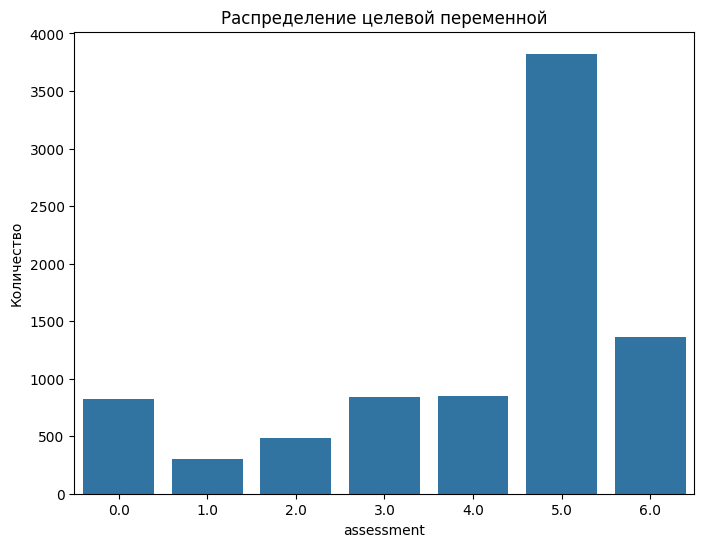

In [4]:
# Исследовательский анализ данных

# Посмотрим на распределение целевой переменной 'assessment'
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='assessment', data=df)
plt.title('Распределение целевой переменной')
plt.xlabel('assessment')
plt.ylabel('Количество')
plt.show()



На представленном графике демонстрируется распределение целевой переменной assessment с шестью возможными категориями (от 0 до 5). Наиболее часто встречающаяся категория — это "5.0", что указывает на возможное смещение или дисбаланс в распределении классов. Категории "0.0", "1.0" и "2.0" встречаются реже всего. Это может сигнализировать о необходимости применения методов балансировки классов в процессе моделирования для улучшения предсказательной способности модели, особенно если цель — классификация. Дисбаланс классов может влиять на точность модели, так как модель может быть смещена в сторону большего класса.

### Предобработка данных

Мы имее пропуски в двух столбцах assessment и tags. Изучим столбец assessment.

In [5]:
# Смотрим уникальные значения
unique_values = df['assessment'].unique()
print(unique_values)

[ 6.  4.  5.  3.  2.  0.  1. nan]


In [6]:
# Заполним значения в assessment значением -1
df['assessment'].fillna(-1, inplace=True)
# Второй вариант - удалиь пропуски
#df.dropna(subset=['assessment'], inplace=True)

In [7]:
# Смотрим результат заполнения
nan_count = df['assessment'].isna().sum()
print("Количество значений NaN в столбце 'assessment':", nan_count)

Количество значений NaN в столбце 'assessment': 0


Изучим столбец tags.

In [8]:
unique_values = df['tags'].unique()
print(unique_values)

['{ASSORTMENT,PROMOTIONS,DELIVERY}'
 '{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}'
 '{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}' ...
 '{DELIVERY,PRICE,ASSORTMENT,CATALOG_NAVIGATION}'
 '{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,SUPPORT,PRICE}'
 '{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}']


In [9]:
nan_count = df['tags'].isna().sum()
print("Количество значений NaN в столбце 'assessment':", nan_count)

Количество значений NaN в столбце 'assessment': 11


In [10]:
df.dropna(subset=['tags'], inplace=True)
# Заполняем пропуски в 'tags' специальным значением
#df['tags'].fillna('{NO_TAGS}', inplace=True)


In [11]:
df.drop('index', axis=1, inplace=True)

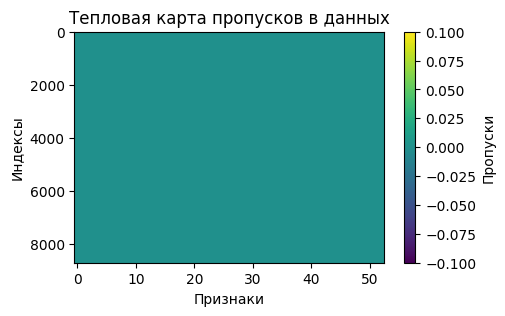

In [12]:
# Создание тепловой карты пропусков
plt.figure(figsize=(5, 3))
plt.imshow(df.isnull(), cmap='viridis', aspect='auto')
plt.colorbar(label='Пропуски')
plt.title('Тепловая карта пропусков в данных')
plt.xlabel('Признаки')
plt.ylabel('Индексы')
plt.show()


Пропуски в данных отсутствуют

Создадим переменные X и y, где X содержит столбец "text" из исходного датафрейма df, а y содержит столбцы с метками классов "trend_id_res0" до "trend_id_res49".  
Преобразуем данные в столбце X в строковый формат, чтобы удостовериться, что все данные являются строками, и создадим копию данных.  
Разделим данные на обучающий (X_train, y_train) и тестовый (X_test, y_test) наборы в соотношении 80/20. Для этого используем функция train_test_split из библиотеки sklearn.model_selection. test_size = 0.2 указывает, что 20% данных будут использоваться для тестирования, а random_state = RANDOM_SEED задает случайное состояние для воспроизводимости результатов. У меня он равен 42ум.  

### Эксперимент

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000) # Вы можете настроить количество фичей
X_tfidf = tfidf.fit_transform(df['text']).toarray()

# Добавление TF-IDF признаков к вашему датафрейму
tfidf_features = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())


In [14]:
# Добавление длины текста как признака
df['text_length'] = df['text'].apply(len)

# Добавление количества уникальных слов
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))


In [15]:
df.head()

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,text_length,unique_words
0,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,82,12
1,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,1
2,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,32,3
3,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34,4
4,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALO...",Доставка просто 👍,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,3


In [16]:
#df.drop('index', axis=1, inplace=True)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8697 entries, 0 to 8707
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   assessment      8697 non-null   float64
 1   tags            8697 non-null   object 
 2   text            8697 non-null   object 
 3   trend_id_res0   8697 non-null   int64  
 4   trend_id_res1   8697 non-null   int64  
 5   trend_id_res2   8697 non-null   int64  
 6   trend_id_res3   8697 non-null   int64  
 7   trend_id_res4   8697 non-null   int64  
 8   trend_id_res5   8697 non-null   int64  
 9   trend_id_res6   8697 non-null   int64  
 10  trend_id_res7   8697 non-null   int64  
 11  trend_id_res8   8697 non-null   int64  
 12  trend_id_res9   8697 non-null   int64  
 13  trend_id_res10  8697 non-null   int64  
 14  trend_id_res11  8697 non-null   int64  
 15  trend_id_res12  8697 non-null   int64  
 16  trend_id_res13  8697 non-null   int64  
 17  trend_id_res14  8697 non-null   int64 

Этот код тогда заморозим

In [18]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer(max_features=1000) # Вы можете настроить количество фичей
#X_tfidf = tfidf.fit_transform(train_df['text']).toarray()

# Добавление TF-IDF признаков к вашему датафрейму
#tfidf_features = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())


In [19]:
# Создание переменных X и y
# X содержит только столбец "text" из исходного датафрейма df
# y содержит столбцы с метками классов "trend_id_res0" до "trend_id_res49"
X, y = df[["text"]], df[[f"trend_id_res{i}" for i in range(50)]]

# Преобразование данных в столбце X в строковый формат
# Это необходимо для обработки текстовых данных
X = X.astype("str").copy()

# Разделение данных на обучающий и тестовый наборы
# В соотношении 80/20, где 80% данных используется для обучения, а 20% - для тестирования
# random_state задает случайное состояние для воспроизводимости результатов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Вывод размеров обучающего и тестового наборов данных
print(f"X_train.shape is {X_train.shape}")
print(f"y_train.shape is {y_train.shape}")
print(f"X_test.shape is {X_test.shape}")
print(f"y_test.shape is {y_test.shape}")


X_train.shape is (6957, 1)
y_train.shape is (6957, 50)
X_test.shape is (1740, 1)
y_test.shape is (1740, 50)


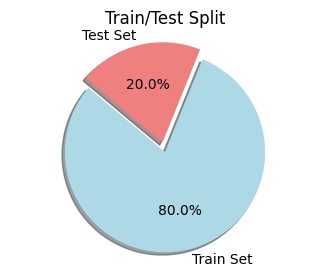

In [20]:
%matplotlib inline
# Создание круговой диаграммы
sizes = [len(X_train), len(X_test)]
labels = ['Train Set', 'Test Set']
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # explode первого сегмента

plt.figure(figsize=(4, 3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Опционально делает круг круглым
plt.title('Train/Test Split')
plt.show()



Разделение прошло успешно! можем двигаться дальше.

Посмотрим баланс классов в данных


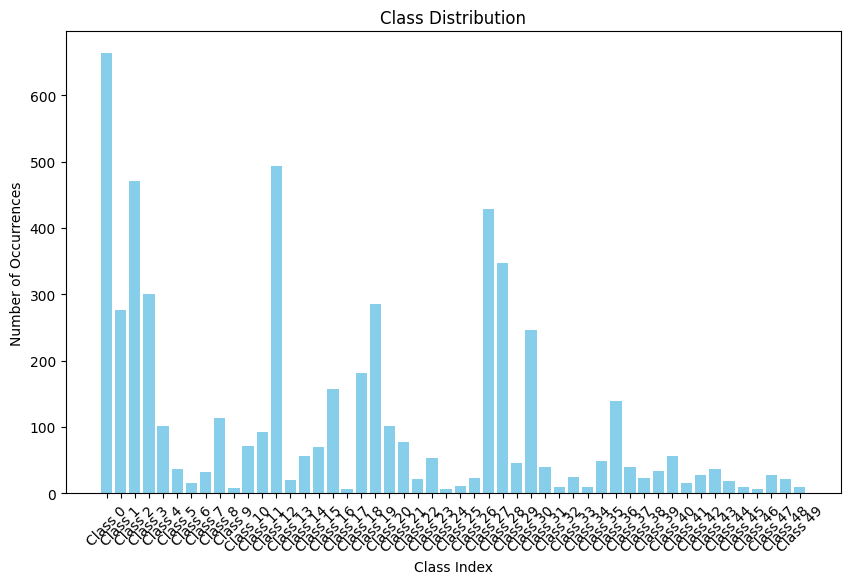

In [21]:
# Подсчет количества появлений каждого класса в y_train
class_counts = y_train.sum(axis=0)

# Визуализация баланса классов
plt.figure(figsize=(10, 6))
plt.bar(range(len(class_counts)), class_counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class Index')
plt.ylabel('Number of Occurrences')
plt.xticks(range(len(class_counts)), [f"Class {i}" for i in range(len(class_counts))], rotation=45)
plt.show()


Из данных таблицы видно, что количество образцов в каждом классе существенно отличается. Некоторые классы имеют намного больше образцов, чем другие. Например, классы "Class 0", "Class 2", "Class 3" имеют значительно большее количество образцов по сравнению с классами "Class 9", "Class 17", "Class 24" и др.
Таким образом, классы не являются сбалансированными, так как имеют значительные различия в количестве образцов между собой. Для улучшения качества модели и ее способности обобщения на всех классах может потребоваться уравнивание количества образцов в каждом классе путем добавления дополнительных данных или использования техник работы с несбалансированными классами, таких как взвешивание классов или использование алгоритмов, учитывающих дисбаланс классов.

### Проверка качества на тречнировчном датасете

Создадим пайплайны для обработки текстовых данных и обучения трех различных классификаторов: логистической регрессии, случайного леса и градиентного бустинга XGBoost (модели машинного обучения, которая используется для классификации данных).

Так же использую ColumnTransformer для предварительной обработки текстовых данных: с созданием preprocessor, который используется для преобразования текстовых данных с помощью TfidfVectorizer и передачи остальных столбцов без изменений.  

Далее осуществим сбор всех пайплайнов в словарь: пайплайны объединяются в словарь pipelines, где ключами являются имена моделей.  

In [22]:
# Определение ColumnTransformer для предварительной обработки текстовых данных
preprocessor = ColumnTransformer(
    [
        ("vetorizer", TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 3)), "text")
    ],
    remainder="passthrough"
)

 # Определение пайплайна для Logistic Regression 1
pipeline_logistic = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", MultiOutputClassifier(LogisticRegression(max_iter=10_000)))
])

# Определение пайплайна для Random Forest Classifier
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", MultiOutputClassifier(RandomForestClassifier(n_jobs=-1, random_state=42)))
])

# Определение пайплайна для Random Forest Classifier с балансировкой классов через подвыборку
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", MultiOutputClassifier(RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced_subsample')))
])

# Определение пайплайна для XGBoost Classifier
#pipeline_xgb = Pipeline([
   # ("preprocessor", preprocessor),
  #  ("clf", MultiOutputClassifier(XGBClassifier(n_jobs=-1, random_state=42)))
#])




# Определение пайплайна для XGBoost Classifier с балансировкой классов
pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", MultiOutputClassifier(XGBClassifier(n_jobs=-1, random_state=42,
                                                 max_depth=6,  # Глубина деревьев
                                                 learning_rate=0.1,  # Скорость обучения
                                                 n_estimators=100,  # Количество деревьев
                                                 min_child_weight=1,  # Минимальный вес дочернего узла
                                                 gamma=0,  # Минимальное снижение потерь для разбиения узла
                                                 subsample=1,  # Доля обучающих экземпляров для построения каждого дерева
                                                 colsample_bytree=1,  # Доля признаков для построения каждого дерева
                                                 reg_alpha=0,  # L1 регуляризация
                                                 reg_lambda=1,  # L2 регуляризация
                                                 scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))  # Балансировка классов
                                                 )))
])



# Собираем все пайплайны в словарь
pipelines = {
    'Logistic Regression': pipeline_logistic,
    'Random Forest Classifier': pipeline_rf,
    'XGBoost Classifier': pipeline_xgb,
}

# Определение пайплайна для CatBoost Classifier
#pipeline_catboost = Pipeline([
  #  ("preprocessor", preprocessor),
   # ("clf", MultiOutputClassifier(CatBoostClassifier(random_state=42, verbose=0)))
#])

pipeline_catboost = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", MultiOutputClassifier(CatBoostClassifier(
        iterations=1000, 
        learning_rate=0.1, 
        depth=6, 
        l2_leaf_reg=3, 
        border_count=32, 
        random_state=42, 
        verbose=0)))
])

# Собираем все пайплайны в словарь
pipelines = {
    'Logistic Regression': pipeline_logistic,
    'Random Forest Classifier': pipeline_rf,
    'XGBoost Classifier': pipeline_xgb,
    'CatBoost Classifier': pipeline_catboost
}

# Выводим пайплайн для Logistic Regression
display(pipeline_logistic, pipeline_rf, pipeline_xgb, pipeline_catboost)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                        n_jobs=-1,
                                                                        random_state=42)))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=1,
                                                               device=None,
                                                               early_stopp...
                                                               gamma=0,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=6,
                                                               max_leaves=None,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x2a5fe3f10>))])

Теперь оценим качество каждой модели из словаря models с использованием кросс-валидации с помощью функции cross_validate и выведем среднюю точность (accuracy) на тестовых данных для каждой модели.

In [23]:
# Оценка качества каждой модели
models = {
    "Logistic Regression": pipeline_logistic,
    "Random Forest Classifier": pipeline_rf,
    "XGBoost Classifier": pipeline_xgb,
    "CatBoost Classifier": pipeline_catboost
}

for model_name, pipeline in models.items():
    results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=["accuracy"], n_jobs=-1)
    mean_accuracy = results["test_accuracy"].mean()
    print(f"Средняя точность на тесте ({model_name}): {mean_accuracy}")


Средняя точность на тесте (Logistic Regression): 0.5094137600502409
Средняя точность на тесте (Random Forest Classifier): 0.4718995058545493
Средняя точность на тесте (XGBoost Classifier): 0.5104207466719552
Средняя точность на тесте (CatBoost Classifier): 0.504239383722948


### P.s. 
Был произведен эксперимент, в ходе которого я добавила параметр class_weight='balanced' для логистической регрессии. После этого метрики упали в 1,5 раза. 
Честно говоря не понимаю, почему так, может датасет все же сбалансирован и поэтому использование балансировки веса привело к переобучению?
Потому что остальные классификаторы эта манипуляция тоже не смогла поднять)

Выполняю предсказания для каждой модели  с использованием кросс-валидации и сохраняю предсказания для обучающих данных.  
Предсказания - это прогнозы моделей для целевой переменной на основе входных данных (X_train) в контексте обучающего набора данных.


In [24]:
# Получение предсказаний для Logistic Regression (cv=2)
y_pred_logistic = cross_val_predict(pipeline_logistic, X_train, y_train, cv=5)

# Получение предсказаний для Random Forest Classifier 
y_pred_rf = cross_val_predict(pipeline_rf, X_train, y_train, cv=5)

# Получение предсказаний для XGBoost Classifier
y_pred_xgb = cross_val_predict(pipeline_xgb, X_train, y_train, cv=5)

# Получение предсказаний для CatBoost Classifier (cv=5)
y_pred_catboost = cross_val_predict(pipeline_catboost, X_train, y_train, cv=5)


Выводим отчет о классификации для каждой модели на обучающем наборе данных.   Отчет о классификации включает различные метрики, такие как точность, полноту, F1-меру и т. д., для каждого класса, а также средневзвешенные значения для всех классов.


В нашей задаче классификации для каждого наблюдения у нас есть 50 классов, так как размерность нашего вектора целевой переменной "y" составляет (6957, 50). Каждый из этих 50 классов представляет различные тенденции (trend_id_res0, trend_id_res1, ..., trend_id_res49).

In [25]:
# Для Logistic Regression
print("Classification Report (Logistic Regression):\n", classification_report(y_train, y_pred_logistic, zero_division=0))

# Для Random Forest Classifier
print("Classification Report (Random Forest Classifier):\n", classification_report(y_train, y_pred_rf, zero_division=0))

# Для XGBoost Classifier
print("Classification Report (XGBoost Classifier):\n", classification_report(y_train, y_pred_xgb, zero_division=0))

# Для CatBoost Classifier
print("Classification Report (CatBoost Classifier):\n", classification_report(y_train, y_pred_catboost, zero_division=0))

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.80      0.31      0.44       663
           1       0.65      0.12      0.21       277
           2       0.69      0.27      0.39       471
           3       0.73      0.20      0.32       300
           4       0.00      0.00      0.00       101
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        32
           8       0.50      0.03      0.05       113
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00        71
          11       0.00      0.00      0.00        92
          12       0.66      0.23      0.34       493
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        56
          15       1.00      0.03      0.06        70
          16       0.00      0.00  

Посмотрим на целевую метрику, т.е. оценку точности (accuracy score) для каждой из трех моделей классификации: Logistic Regression, Random Forest Classifier, CatBoost Classifier и XGBoost Classifier. Точность вычислим путем сравнения предсказанных значений с истинными значениями для обучающего набора данных (y_train).







In [26]:
# Для Logistic Regression
accuracy_logistic = accuracy_score(y_train, y_pred_logistic)
print("Accuracy Score (Logistic Regression):", accuracy_logistic)

# Для Random Forest Classifier
accuracy_rf = accuracy_score(y_train, y_pred_rf)
print("Accuracy Score (Random Forest Classifier):", accuracy_rf)

# Для XGBoost Classifier
accuracy_xgb = accuracy_score(y_train, y_pred_xgb)
print("Accuracy Score (XGBoost Classifier):", accuracy_xgb)

# Для CatBoost Classifier
accuracy_catboost = accuracy_score(y_train, y_pred_catboost)
print("Accuracy Score (CatBoost Classifier):", accuracy_catboost)

Accuracy Score (Logistic Regression): 0.5094149777202818
Accuracy Score (Random Forest Classifier): 0.4718988069570217
Accuracy Score (XGBoost Classifier): 0.51042115854535
Accuracy Score (CatBoost Classifier): 0.5042403334770734


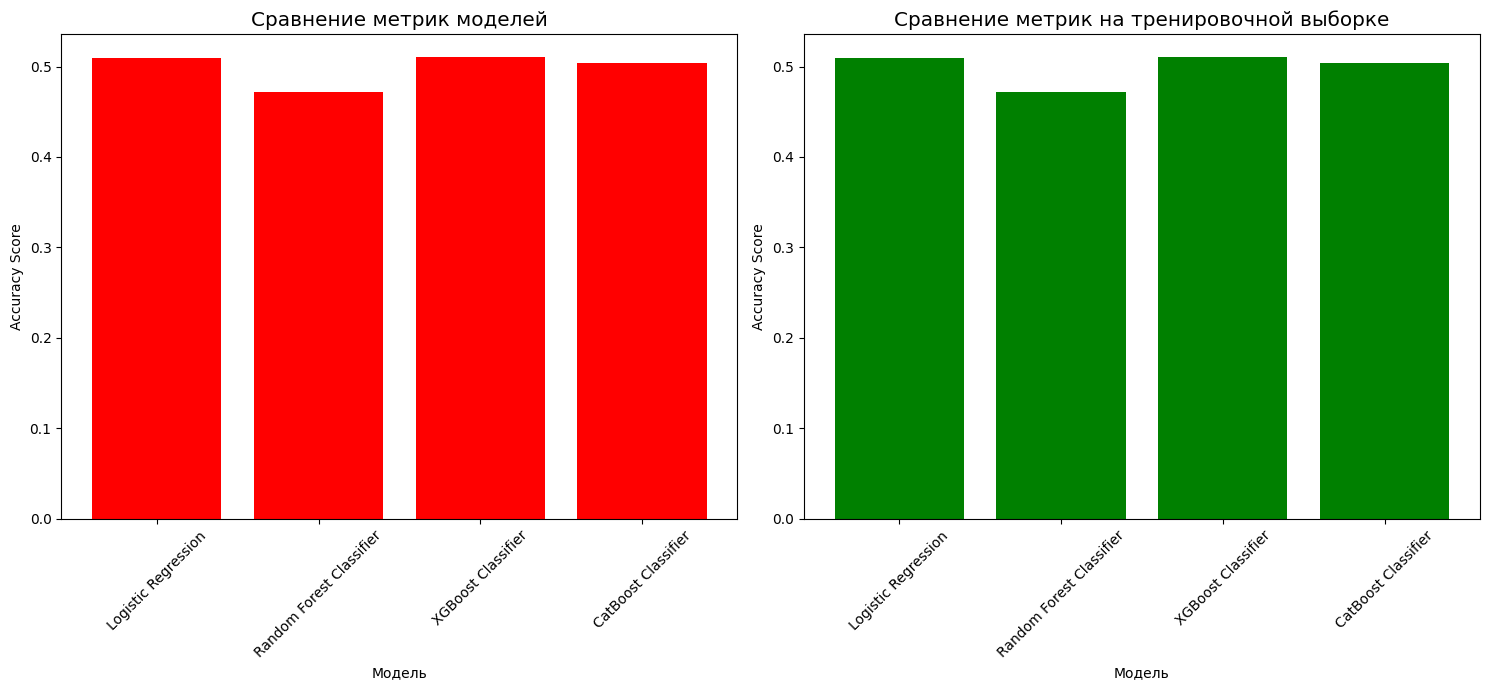

In [27]:
# Собираем значения Accuracy Score для каждой модели в датафрейм
accuracy_scores = {
    "Logistic Regression": accuracy_score(y_train, y_pred_logistic),
    "Random Forest Classifier": accuracy_score(y_train, y_pred_rf),
    "XGBoost Classifier": accuracy_score(y_train, y_pred_xgb),
    "CatBoost Classifier": accuracy_score(y_train, y_pred_catboost)
}

analisys = pd.DataFrame({'names': list(accuracy_scores.keys()), 'Accuracy Score': list(accuracy_scores.values())})

# Строим графики
plt.figure(figsize=(15, 7))

# График для сравнения метрик моделей
plt.subplot(1, 2, 1)
plt.bar(analisys['names'], analisys['Accuracy Score'], color='red')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)

# График для сравнения метрик на тренировочной выборке
plt.subplot(1, 2, 2)
plt.bar(analisys['names'], analisys['Accuracy Score'], color='green')
plt.title('Сравнение метрик на тренировочной выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [28]:
accuracy_scores = {
    'Logistic Regression': accuracy_score(y_train, y_pred_logistic),
    'Random Forest Classifier': accuracy_score(y_train, y_pred_rf),
    'XGBoost Classifier': accuracy_score(y_train, y_pred_xgb),
    'CatBoost Classifier': accuracy_score(y_train, y_pred_catboost)
}

best_model = max(accuracy_scores, key=accuracy_scores.get)
best_accuracy = accuracy_scores[best_model]

print(f"Лучшая модель по Accuracy Score: {best_model}")
print(f"Accuracy Score для лучшей модели: {best_accuracy:.4f}")


Лучшая модель по Accuracy Score: XGBoost Classifier
Accuracy Score для лучшей модели: 0.5104


### Тренировка окончательной модели

In [32]:
#pipeline_logistic.fit(X_train, y_train)
#pipeline_rf.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)
#pipeline_catboost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vetorizer',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text')])),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=1,
                                                               device=None,
                                                               early_stopp...
                                                               gamma=0,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=6,
                                                               max_leaves=None,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)))])

### Предсказание и загрузка решения


res.iloc[:, 1:].sum(): Вычисляет сумму по каждому столбцу, начиная с первого (после столбца с индексами). Это позволяет подсчитать количество предсказанных объектов для каждого класса.
res["trend_id_res0"].value_counts(): Подсчитывает количество объектов с каждым уникальным значением в столбце "trend_id_res0". Это позволяет оценить распределение предсказаний для конкретного класса.
res[["index"]+[f"trend_id_res{i}" for i in range(50)]].to_csv("submission.csv", index=False): Сохраняет DataFrame res в файл "submission.csv" без индексов. Этот файл может быть представлен в качестве ответа на задачу или использован для оценки модели на внешнем тестовом наборе данных.






Загрузим тестовый набор данных из файла "test.csv" в DataFrame test

In [33]:
test =  pd.read_csv("test.csv")

Применим обученную модель XGBoost Classifier к текстовым данным из столбца "text" тестового набора данных test и делает предсказания для каждого класса. Предсказания сохраним в переменную pred_test.

In [34]:
pred_test = pipeline_xgb.predict(test[["text"]].astype("str"))

Создадим DataFrame res, в котором первый столбец содержит индексы объектов из тестового набора данных, а остальные столбцы содержат предсказанные метки для каждого класса (trend_id_res0, trend_id_res1, ..., trend_id_res49).

In [35]:
res = pd.DataFrame(np.hstack([test["index"].values.reshape(test.shape[0], 1), pred_test]),
                  columns = ["index"]+[f"trend_id_res{i}" for i in range(50)])

In [36]:
res.head(5)

,index,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9285,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4655,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Вычисляем сумму по каждому столбцу, начиная с первого (после столбца с индексами). Это позволяет подсчитать количество предсказанных объектов для каждого класса.

In [37]:
res.iloc[:, 1:].sum()

trend_id_res0     1022
trend_id_res1      387
trend_id_res2      747
trend_id_res3      342
trend_id_res4       31
trend_id_res5       39
trend_id_res6        0
trend_id_res7        6
trend_id_res8       95
trend_id_res9        0
trend_id_res10      28
trend_id_res11     182
trend_id_res12    1131
trend_id_res13       0
trend_id_res14       5
trend_id_res15     109
trend_id_res16     104
trend_id_res17       0
trend_id_res18       8
trend_id_res19     358
trend_id_res20     139
trend_id_res21      61
trend_id_res22       6
trend_id_res23      39
trend_id_res24       0
trend_id_res25       0
trend_id_res26       0
trend_id_res27     442
trend_id_res28     601
trend_id_res29       0
trend_id_res30     606
trend_id_res31       6
trend_id_res32       0
trend_id_res33      48
trend_id_res34       2
trend_id_res35      50
trend_id_res36     135
trend_id_res37       4
trend_id_res38      17
trend_id_res39       0
trend_id_res40      18
trend_id_res41       0
trend_id_res42       7
trend_id_re

Подсчитаем количество объектов с каждым уникальным значением в столбце "trend_id_res0". Это позволяет оценить распределение предсказаний для конкретного класса.

In [38]:
res["trend_id_res0"].value_counts()

trend_id_res0
0    15977
1     1022
Name: count, dtype: int64

Сохраняем DataFrame res в файл "submission.csv" без индексов. Этот файл будет представлен в качестве ответа на задачу и использован для оценки модели на внешнем тестовом наборе данных.


In [39]:
res[["index"]+[f"trend_id_res{i}" for i in range(50)]].to_csv("submission.csv", index=False)

### Вывод:
Загрузка и предварительная обработка данных: Данные загружаются из файлов train.csv и trends_description.csv. Затем проводится предварительная обработка данных, включающая заполнение пропущенных значений и разделение на обучающий и тестовый наборы.

Подготовка и обучение моделей: Используются три различные модели машинного обучения - Logistic Regression, Random Forest Classifier и XGBoost Classifier. Каждая модель обучается на обучающем наборе данных после предварительной обработки текстовых данных с использованием TF-IDF векторизации.

Оценка качества моделей: Качество каждой модели оценивается с помощью метрики Accuracy Score на обучающем наборе данных с использованием кросс-валидации.

Выбор лучшей модели: Выбирается модель с наилучшим показателем Accuracy Score.

Генерация предсказаний для тестового набора данных: Лучшая модель используется для предсказания значений целевых переменных на тестовом наборе данных. Предсказанные значения сохраняются в файл submission.csv.  
 
В итоге, XGBoost Classifier демонстрирует немного лучшую общую точность по сравнению с остальными моделями. Однако, все модели показывают низкую эффективность в классификации многих категорий, что видно по низким показателям recall и precision для большинства классов. Это может указывать на необходимость дальнейшей оптимизации моделей и возможно на потребность в более качественных или разнообразных данных для обучения.  




In [40]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
